## How can we predict survival on the Titanic?

to do list for self
- 1 apply fcc principles
- 2 apply [https://www.linkedin.com/pulse/what-i-learned-analyzing-famous-titanic-dateset-murilo-gustineli/]
- 3 apply [https://python.plainenglish.io/revitalizing-cyclistic-bike-share-program-an-in-depth-data-exploration-556b52512bf8] - diff dataset but still
- 4 apply others? [https://www.kaggle.com/code/startupsci/titanic-data-science-solutions]

### Guiding Questions
- Which features are correlated with survival?
- Can we accurately predict survival with a simple model?
- Which model performs best on this dataset?





say somewhere how i experimented with mean age/fare vs. median.... mean fared better (no pun intended). also engineered features such as the deck they were on (A-G, T, N/A => Unknown) and from EDA seemed like B-E were high survival decks so logically made sense to include binary var of whether they were on that deck (and deck was derived from the letter/starting char of the cabin column)

note: could also see if the number is meaningful???


In [190]:
# import statements
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [191]:
# import train and test datasets and find length, info(), and describe() summary statistics
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
print(f"Passengers in train set: {train_df.shape[0]}\nPassengers in test set: {test_df.shape[0]}")

Passengers in train set: 891
Passengers in test set: 418


891:418 which roughly equals a 7:3 ratio of train:test rows (before dropping any training rows as needed???)

In [192]:
print(train_df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### Dataset description

| Column | dtype | Description |
|----------|----------|----------|
| PassengerId  | int64  | unique passenger  |
| Survived  | int64  | binary value of survival outcome (0, 1)  |
| Pclass  | int64  | class (1, 2, 3)  |
| Name  | object  | string value for name --> to quantify in feature engineering, we deduced title from this as well as name length  |
| Sex  | object  | sex ("male", "female")  |
| Age  | float64  | passenger's age at time of ?  |
| SibSp  | int64  | sibling/spouse #?  |
| Parch  | int64  | parents/children #?  |
| Ticket  | object?  | ?  |
| Fare  | float64  | ticket cost LOGGED ITTTTTTT |
| Cabin  | object  | cabin identifer of format letter + number (e.g. C85, C123, B42, C148) - from research, letter corresponds to deck which we engineered our own feature from this  |
| Embarked  | object  | port passenger boarded from? ('S', 'C', 'Q' which correspond to Southampton, Cherbourg, Queenstown)  |

NOTE - variations to help algorithm?
- deal with fare, cabin, age dropped values differently!

In [193]:
train_df["Embarked"].str[0].unique()
train_df["Cabin"].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [194]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [195]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [196]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [197]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We see that the Age, Cabin, and Embarked have null values to be dealt with/cleaned in the train datset

In [198]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [199]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [200]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We see that the Age, Fare, Cabin have null values to be dealt with/cleaned in the train datset

Next, let's look at statistic summaries of datasets

In [201]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [202]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


We see train and test df have similar summary statistics. from first glance, all columns seem to have reasonable means and min/max (pclass 1-3 all valid, age in right range, # sibs or parch as well as fare all seem reasonable with no outright impossible valus/outliers - though fare seems to be very right skewed)

we will look into each variable distribution more to see if any single varaible distribution can be preprocessed or cleaned

In [203]:
# sanity checks
print(f"Minimum age: {train_df['Age'].min()}. Maximum age: {train_df['Age'].max()}.")
print(f"Duplicate PassengerIds? {train_df.duplicated('PassengerId').sum()}")

Minimum age: 0.42. Maximum age: 80.0.
Duplicate PassengerIds? 0


First let's figure out to deal with missing AGE and CABIN columns which there are a lot of in train and test. but we'll only look at train set??

### EDA

- Visualize survival by class, sex, age, family, fare
- Show correlations (heatmap, groupby stats)
- Write observations inline

## Visualizing each variable (pre cleaning/n/a values)

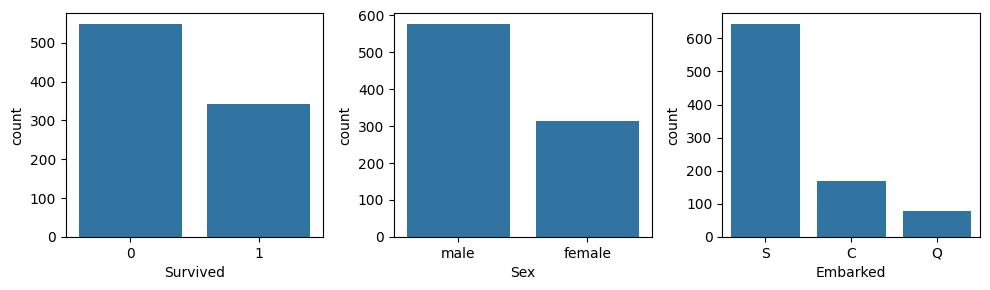

In [204]:
#sns.countplot for each categorical attributes cumulative
#AND sns.countplot for each categorical attributes by died/survived
    #survived, sex, embarked

fig, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=3)
sns.countplot(x="Survived", data=train_df, ax=axes[0])
sns.countplot(x="Sex", data=train_df, ax=axes[1])
sns.countplot(x="Embarked", data=train_df, ax=axes[2])
fig.tight_layout()

We see that majority perished in titanic, there were more male aboard, and most embarked from 'S' in the train set

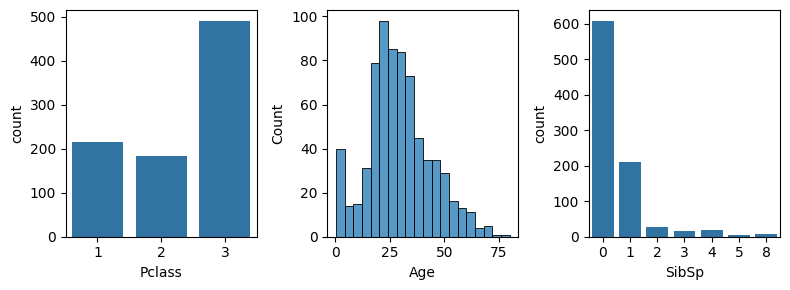

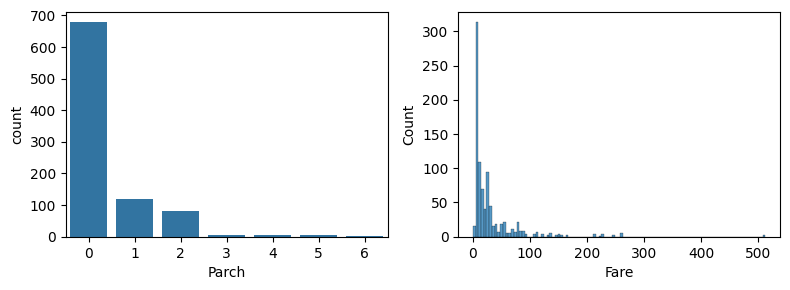

In [205]:
#sns.distplot for numerical attirbutes
#pclass, age, sibsp, parch, fare

fig1, axes1 = plt.subplots(figsize=(8, 3), nrows=1, ncols=3)
fig2, axes2 = plt.subplots(figsize=(8, 3), nrows=1, ncols=2)
sns.countplot(x="Pclass", data=train_df, ax=axes1[0])
sns.histplot(x="Age", data=train_df, ax=axes1[1])
sns.countplot(x="SibSp", data=train_df, ax=axes1[2])
sns.countplot(x="Parch", data=train_df, ax=axes2[0])
sns.histplot(x="Fare", data=train_df, ax=axes2[1])
fig1.tight_layout()
fig2.tight_layout()

majority of passengers in 3rd class, then 1st, then 2nd. age seems normally distributed (???). sib sp and parch seem similar right skewed most had 0. fare seems very right skewed so may need to be normalized(???) - example used log but other methods?

<Axes: xlabel='Fare_log', ylabel='Count'>

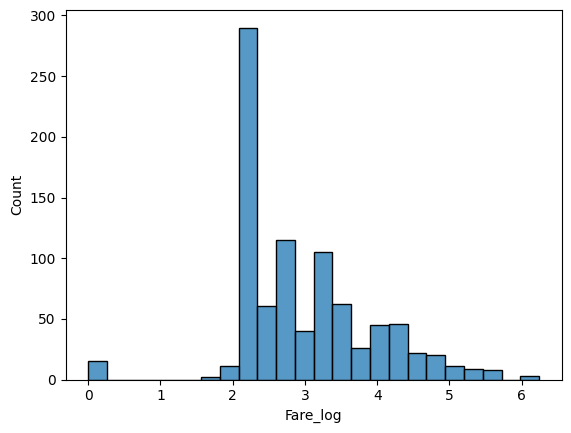

In [206]:
# random note - should we apply log to fare? yes
import numpy as np

train_df['Fare_log'] = np.log1p(train_df['Fare'])  # log1p avoids log(0) errors
sns.histplot(x="Fare_log", data=train_df)


for managing cabin, since it's a string we'll just set to "Unknown" for fillna. it seems that one thing we can feature engineeri extract the first letter which is the "deck" that a passenger stayed on so
- deck fillna with "Unknown"
- we will create a "deck" which is the first letter of the "cabin."

In [207]:
#fill deck nan with "U"
train_df['Cabin'].fillna('Unknown', inplace=True)
train_df["Deck"] = train_df["Cabin"].str[0] # U = unknown
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,2.110213,U
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,2.188856,U
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,2.202765,U


feature engineering for NAME
- the "name" is of format "[surname], [title], [first and middle etc name/nicknames]" which we can deduce "surname length", "title" and "first name length" from which i imagine are more meaningful features than name - so i will deduce "surname" and "title" and then drop calculate teh lenght of the remaining first name

TICKET
- will also drop because seems unhelpful/unstandardized

In [208]:
train_df["Surname Length"] = train_df["Name"].str.split(',').str[0].str.len()
train_df["Title"] = train_df["Name"].str.split(',').str[1].str.split(' ').str[1]
train_df["First Name Length"] = train_df["Name"].str.split(',').str[1].str.split(". ", regex=False).str[1].str.len()
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log,Deck,Surname Length,Title,First Name Length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,2.110213,U,6,Mr.,11
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,C,7,Mrs.,37
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,2.188856,U,9,Miss.,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,C,8,Mrs.,29
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,2.202765,U,5,Mr.,13


In [209]:
train_df["Title"].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64

In [210]:
train_df[train_df["Title"] == "the"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log,Deck,Surname Length,Title,First Name Length
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,4.471639,B,6,the,34


categorizing the titles into meaningful categories that takes into account marital status which could equate to class as well as how rare the titels are (e.g. "the" is for "the Countess")

In [211]:
title_mapping = {
    "Mr.": "Mr",
    "Mrs.": "Mrs",
    "Miss.": "Miss",
    "Ms.": "Miss",       # Unmarried woman (modern)
    "Mlle.": "Miss",     # French for Miss
    "Mme.": "Mrs",       # French for Mrs
    "Master.": "Master", # Usually boys under 12
    "Dr.": "Rare",       # Ambiguous — could be male or female
    "Rev.": "Rare",
    "Major.": "Rare",
    "Col.": "Rare",
    "Capt.": "Rare",
    "Sir.": "Rare",
    "Lady.": "Rare",
    "Don.": "Rare",
    "Jonkheer.": "Rare",
    "the": "Rare"
}

In [212]:
train_df["Title"] = train_df["Title"].map(title_mapping)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log,Deck,Surname Length,Title,First Name Length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,2.110213,U,6,Mr,11
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,C,7,Mrs,37
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,2.188856,U,9,Miss,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834,C,8,Mrs,29
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,2.202765,U,5,Mr,13


make sex into binary feature

In [213]:
train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})

ok now help me apply get_dummy prior to correlation heatmap to see if embarked, deck, or title have meaning

and then drop name and ticket and cabin columns

In [214]:
train_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log,Deck,Surname Length,Title,First Name Length
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,Unknown,S,2.110213,U,6,Mr,11


(0.0, 50.0)

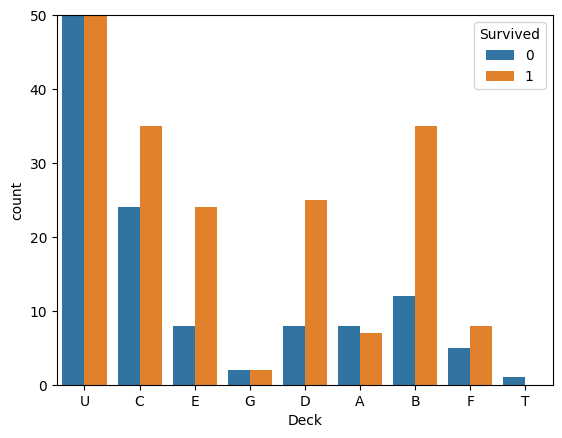

In [215]:
# look at deck survival correlation

sns.countplot(x='Deck', hue='Survived', data=train_df)
plt.ylim(top=50)


--> decision to bucket! (movea fter correlation? or something)

then add dummy data for categories like embarked

In [216]:
train_df = pd.get_dummies(train_df, columns=["Deck", "Embarked", "Title"])
train_df.drop(axis=1, columns=['Name', 'Ticket', 'Cabin'], inplace=True)
print(train_df.columns)
train_df.head(1)

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Fare_log', 'Surname Length', 'First Name Length', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Deck_U', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,Surname Length,...,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,3,0,22.0,1,0,7.25,2.110213,6,...,0,1,0,0,1,0,0,1,0,0


In [217]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,Surname Length,...,Deck_T,Deck_U,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,0,3,0,22.0,1,0,7.2500,2.110213,6,...,0,1,0,0,1,0,0,1,0,0
1,2,1,1,1,38.0,1,0,71.2833,4.280593,7,...,0,0,1,0,0,0,0,0,1,0
2,3,1,3,1,26.0,0,0,7.9250,2.188856,9,...,0,1,0,0,1,0,1,0,0,0
3,4,1,1,1,35.0,1,0,53.1000,3.990834,8,...,0,0,0,0,1,0,0,0,1,0
4,5,0,3,0,35.0,0,0,8.0500,2.202765,5,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,2.639057,8,...,0,1,0,0,1,0,0,0,0,1
887,888,1,1,1,19.0,0,0,30.0000,3.433987,6,...,0,0,0,0,1,0,1,0,0,0
888,889,0,3,1,NaN,1,2,23.4500,3.196630,8,...,0,1,0,0,1,0,1,0,0,0
889,890,1,1,0,26.0,0,0,30.0000,3.433987,4,...,0,0,1,0,0,0,0,1,0,0


<Axes: >

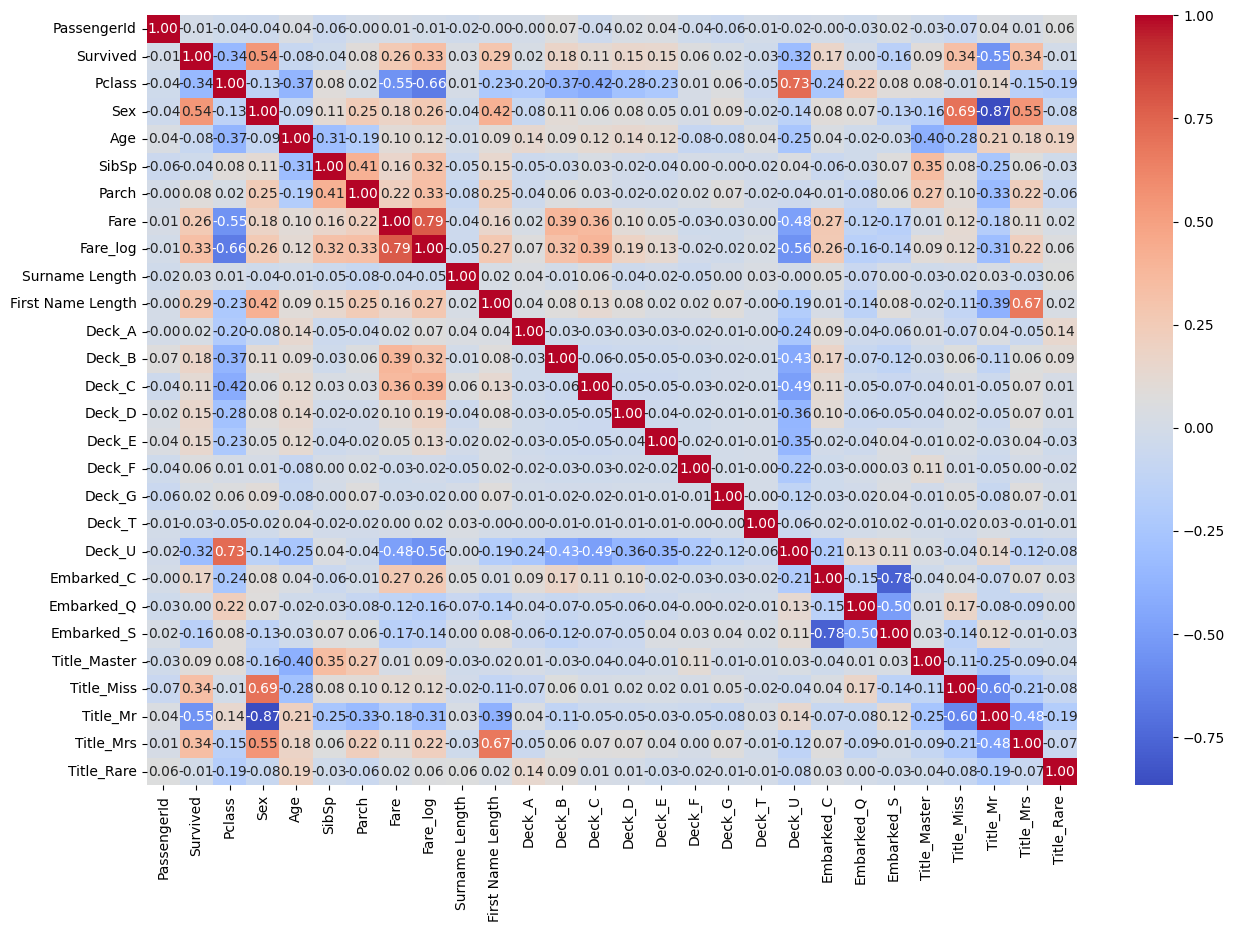

In [218]:
# to answer 'Which features are correlated with survival?' correlation plot

corr = train_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

DROPPING

**Embarked_Q** → near 0 correlation

**Deck_A, Deck_G, Deck_T** → too rare or no predictive value so dropping

**Title_*** → only Mr, Miss, Mrs were correlated which is redundant with Sex

**Surname Length** 0 correlation

**Deck_U**

ADDING IN/TWEAKING

**Decks B-E** were high survival decks --> add a bucket feature

In [219]:
train_df['High Survival Deck'] = (train_df['Deck_B']) | (train_df['Deck_C']) | (train_df['Deck_D']) | (train_df['Deck_E'])
train_df.drop(axis=1, columns=['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Embarked_Q', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Surname Length'], inplace=True)
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Deck_U,Embarked_C,Embarked_S,High Survival Deck
0,1,0,3,0,22.0,1,0,7.2500,2.110213,11,1,0,1,0
1,2,1,1,1,38.0,1,0,71.2833,4.280593,37,0,1,0,1
2,3,1,3,1,26.0,0,0,7.9250,2.188856,5,1,0,1,0
3,4,1,1,1,35.0,1,0,53.1000,3.990834,29,0,0,1,1
4,5,0,3,0,35.0,0,0,8.0500,2.202765,13,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,2.639057,6,1,0,1,0
887,888,1,1,1,19.0,0,0,30.0000,3.433987,14,0,0,1,1
888,889,0,3,1,NaN,1,2,23.4500,3.196630,24,1,0,1,0
889,890,1,1,0,26.0,0,0,30.0000,3.433987,11,0,1,0,1


<Axes: >

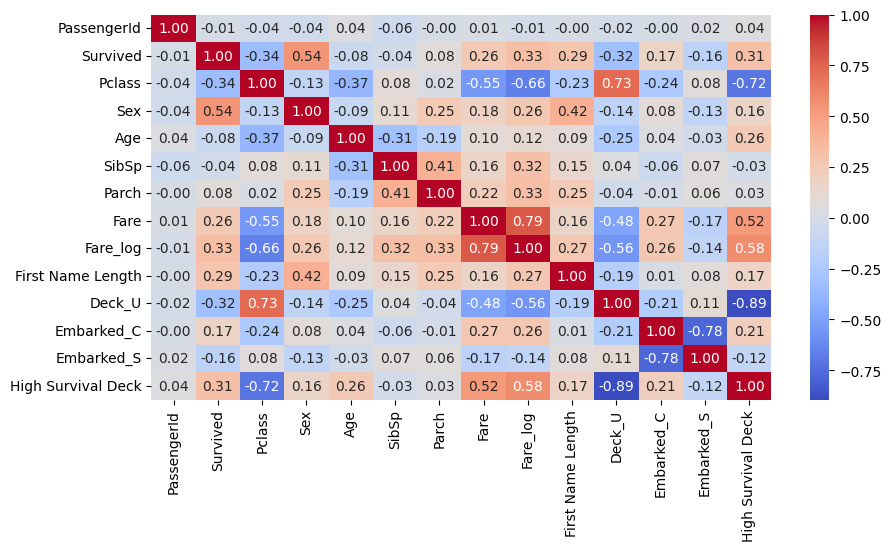

In [220]:
# we try again

corr = train_df.corr()
plt.subplots(figsize=(10,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

### Data Cleaning (i guess above is hybrid data cleaning/feature engineering/preprocessing combo - can separate out for clarity)

- describe data
- Of the estimated 2,224 passengers and crew aboard, approximately 1,500 died (estimates vary) [https://en.wikipedia.org/wiki/Titanic]
- 891 entries in the training set
- 418 in the test set
- 1309 total meaning a rougly 7:3 split for train:test

x

- Inspect nulls
- Drop/recode columns
- Feature engineering

given our EDA, age is not super correlated variable so prob fine to set to mean of train_df (can also try ommitting, and maybe setting to mean)

In [221]:
# fill age na values
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
train_df.isna().sum()

PassengerId           0
Survived              0
Pclass                0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Fare                  0
Fare_log              0
First Name Length     0
Deck_U                0
Embarked_C            0
Embarked_S            0
High Survival Deck    0
dtype: int64

In [222]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Deck_U,Embarked_C,Embarked_S,High Survival Deck
0,1,0,3,0,22.000000,1,0,7.2500,2.110213,11,1,0,1,0
1,2,1,1,1,38.000000,1,0,71.2833,4.280593,37,0,1,0,1
2,3,1,3,1,26.000000,0,0,7.9250,2.188856,5,1,0,1,0
3,4,1,1,1,35.000000,1,0,53.1000,3.990834,29,0,0,1,1
4,5,0,3,0,35.000000,0,0,8.0500,2.202765,13,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,13.0000,2.639057,6,1,0,1,0
887,888,1,1,1,19.000000,0,0,30.0000,3.433987,14,0,0,1,1
888,889,0,3,1,29.699118,1,2,23.4500,3.196630,24,1,0,1,0
889,890,1,1,0,26.000000,0,0,30.0000,3.433987,11,0,1,0,1


last test - remove top and bottom quartiles for pclass, age, fare

In [ ]:
# tried removing lowest and top 2.5% outliers but did not help

# pclass_mask = (train_df['Pclass'] >= train_df['Pclass'].quantile(0.025)) & (train_df['Pclass'] <= train_df['Pclass'].quantile(0.975))
# age_mask = (train_df['Age'] >= train_df['Age'].quantile(0.025)) & (train_df['Age'] <= train_df['Age'].quantile(0.975))
# fare_mask = (train_df['Fare'] >= train_df['Fare'].quantile(0.025)) & (train_df['Fare'] <= train_df['Fare'].quantile(0.975))

# train_df = train_df[pclass_mask & age_mask & fare_mask]

train is all set! now let's fun it to get validation accuracy acros smodels to find best one

In [224]:
#HEY REMOVE QUARTILES OR NAH

In [225]:
# general code to get CV accuracy of model

from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def evaluate_model(model, X, y, cv=5, scoring='accuracy'):
    """Evaluate a model using cross-validation."""
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f"{model} Mean: {np.mean(scores)})")
    return scores

In [226]:
train_df.head(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Deck_U,Embarked_C,Embarked_S,High Survival Deck
0,1,0,3,0,22.0,1,0,7.2500,2.110213,11,1,0,1,0
1,2,1,1,1,38.0,1,0,71.2833,4.280593,37,0,1,0,1


In [227]:
X_train = train_df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log', 'First Name Length', 'Embarked_C', 'Embarked_S', 'High Survival Deck']]
y_train = train_df['Survived']

In [228]:
X_train.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Embarked_C,Embarked_S,High Survival Deck
0,1,3,0,22.0,1,0,7.25,2.110213,11,0,1,0


In [229]:
y_train.head(1)

0    0
Name: Survived, dtype: int64

In [230]:
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import warnings

# Define models
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
dectree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()
svm = SVC()
gradboost = GradientBoostingClassifier()
percep = Perceptron()

# Evaluate
evaluate_model(logreg, X_train, y_train)
evaluate_model(rf, X_train, y_train)
evaluate_model(dectree, X_train, y_train)
evaluate_model(knn, X_train, y_train)
evaluate_model(nb, X_train, y_train)
evaluate_model(svm, X_train, y_train)
evaluate_model(gradboost, X_train, y_train)
evaluate_model(percep, X_train, y_train)

# suppress warnings
warnings.filterwarnings("ignore")


LogisticRegression(max_iter=1000) Mean: 0.7909338786639399)
RandomForestClassifier() Mean: 0.7884571688252671)
DecisionTreeClassifier() Mean: 0.7306824206619706)
KNeighborsClassifier() Mean: 0.5252442626675755)
GaussianNB() Mean: 0.7454820874043777)
SVC() Mean: 0.6531394380065138)
GradientBoostingClassifier() Mean: 0.7675982731197455)
Perceptron() Mean: 0.5856774975384382)


random forest is da best so we go w it

### Modeling

- 5 models: Logistic Regression, Decision Tree, Random Forest, KNN, Naive Bayes
- Optionally: SVM, Gradient Boosting, or Perceptron
- Compare accuracy, precision, recall, AUC
- Pick a best model + explain why

### 1) Logistic Regression model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

need to get test_df ship shape for running models!

In [231]:
# log reg code
y_train = train_df['Survived']
X_test = test_df
# gotta clean up test so matches formattttt
X_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [232]:
X_test['Fare_log'] = np.log1p(X_test['Fare'])  # log1p avoids log(0) errors
X_test['Fare_log'].fillna(X_test['Fare_log'].mean(), inplace=True)
X_test['Cabin'].fillna('Unknown', inplace=True)
X_test["Deck"] = X_test["Cabin"].str[0] # U = unknown
X_test["Surname Length"] = X_test["Name"].str.split(',').str[0].str.len()
X_test["First Name Length"] = X_test["Name"].str.split(',').str[1].str.split(". ", regex=False).str[1].str.len()
X_test['Sex'] = X_test['Sex'].map({'male':0, 'female':1})
X_test = pd.get_dummies(X_test, columns=["Embarked"])
X_test['High Survival Deck'] = (X_test['Deck'].isin(['B', 'C', 'D', 'E'])).astype(int)
# X_test.insert(14, 'Deck Unknown', (X_test['Deck'] == "U").astype(int))
# X_test.drop(axis=1, columns=['Name', 'Ticket', 'Cabin', 'Deck', 'Surname Length', 'Embarked_Q'], inplace=True)
X_test = X_test[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log', 'First Name Length', 'Embarked_C', 'Embarked_S', 'High Survival Deck']]
X_test.head(2)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Embarked_C,Embarked_S,High Survival Deck
0,892,3,0,34.5,0,0,7.8292,2.178064,5,0,0,0
1,893,3,1,47.0,1,0,7.0000,2.079442,19,0,1,0


In [233]:
X_train.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Embarked_C,Embarked_S,High Survival Deck
0,1,3,0,22.0,1,0,7.2500,2.110213,11,0,1,0
1,2,1,1,38.0,1,0,71.2833,4.280593,37,1,0,1
2,3,3,1,26.0,0,0,7.9250,2.188856,5,0,1,0
3,4,1,1,35.0,1,0,53.1000,3.990834,29,0,1,1
4,5,3,0,35.0,0,0,8.0500,2.202765,13,0,1,0


In [234]:
X_test.head(5)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_log,First Name Length,Embarked_C,Embarked_S,High Survival Deck
0,892,3,0,34.5,0,0,7.8292,2.178064,5,0,0,0
1,893,3,1,47.0,1,0,7.0000,2.079442,19,0,1,0
2,894,2,0,62.0,0,0,9.6875,2.369075,14,0,0,0
3,895,3,0,27.0,0,0,8.6625,2.268252,6,0,1,0
4,896,3,1,22.0,1,1,12.2875,2.586824,29,0,1,0


In [235]:
y_train.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [236]:
# !pip install scikit-learn --> add this to enviro
# log reg!

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [237]:
submission = pd.read_csv('titanic/gender_submission.csv')
submission['Survived'] = y_pred
submission # 75% --> answer to 'Can we accurately predict survival with a simple model?'

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [238]:
submission.to_csv('submissions/final_test.csv', index=None)

### 2) Decision Tree model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [239]:
# decision tree code

### 3) Random Forest

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [240]:
# random forest code

### 4) KNN model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [241]:
# KNN code

### 5) Naive Bayes model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [242]:
# Naive Bayes code

### 6) SVM model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [243]:
# SVM code

### 7) Gradient Boosting model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [244]:
# Gradient Boosting code

### 8) Perceptron model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

In [245]:
# Perceptron code

### Final Evaluation

- Confusion matrix, F1, ROC curve
- Feature importance chart

In [246]:
# final eval

In [247]:
# to answer 'Which model performs best on this dataset?'ArithmeticError

best_model!

SyntaxError: invalid syntax (3703367581.py, line 3)

[write up too]

### Wrap-up
- Final thoughts, takeaways
- What you’d do next with more time/data
- References or inspiration sources

[writeup]

# References
- Titanic - Machine Learning from Disaster [https://www.kaggle.com/competitions/titanic/data]
- Titanic (wikipedia) [https://en.wikipedia.org/wiki/Titanic]
- cleaning data [https://www.youtube.com/watch?v=cWf08xuSqdU&ab_channel=DataGeekismyname]